# Modelling event times on the Santander Cycles data using graph-based mutually exciting processes (GB-MEP)
First, import the library `gb_mep`:

In [12]:
## Import library gb_mep
import gb_mep

Next, import the Santander Cycles data from the directory `data` (after running the scripts for data preprocessing, as detailed in the main `README` file for the library `gb_mep`).

In [13]:
## Load all required files after importing relevant libraries
import pickle
import numpy as np
import pandas as pd
santander_train = pd.read_csv('../data/santander_train.csv') 
santander_test = pd.read_csv('../data/santander_test.csv') 
santander_distances = np.load('../data/santander_distances.npy')
with open('../data/santander_dictionary.pkl', 'rb') as f:
    santander_dictionary = pickle.load(f)


Inspect the Santander Cycles data:

In [14]:
santander_train

,start_id,end_id,start_time,end_time
0,722,131,0.483492,13.192747
1,531,460,0.484768,23.477447
2,515,603,0.624303,4.196019
3,804,689,0.807900,13.604670
4,740,48,1.568787,31.912915
...,...,...,...,...
6453258,302,637,241912.321072,241919.498489
6453259,740,342,241912.686823,241919.489431
6453260,327,324,241913.941339,241917.596443
6453261,224,337,241913.962367,241919.498538


Define a `gb_mep` object `G` using the DataFrame `santander_train`, mapping of station names to labels given by `santander_dictionary`, and matrix of node distances `santander_distances`, and define two dictionaries `start_times` and `end_times` from `G` via the function `augment_start_times`, with input `santander_test`:

In [15]:
G = gb_mep.gb_mep(df=santander_train, id_map=santander_dictionary, distance_matrix=santander_distances)
start_times, end_times = G.augment_start_times(santander_test)

Fit a Poisson process to the training data used to construct `G`:

In [16]:
res_pp = G.fit_poisson()

Fit a mutually exciting process to the training data used to construct `G`, which models to the start times only as a function of the end times at the same station:

In [17]:
res_mep = G.fit(x0=-np.ones(3), subset_nodes=range(3), start_times=False, end_times=True, distance_start=False, distance_end=False)

Fit a self-exciting process to the training data used to construct `G`, which models to the start times only as a function of the start times at the same station:

In [18]:
res_sep = G.fit(x0=-np.ones(3), subset_nodes=range(3), start_times=True, end_times=False, distance_start=False, distance_end=False)

Fit a self-and-mutually exciting process to the training data used to construct `G`, which models to the start times only as a function of the event times occurred at the same station:

In [19]:
res_smep = G.fit(x0=-np.ones(5), subset_nodes=range(3), start_times=True, end_times=True, distance_start=False, distance_end=False)

In [20]:
res_gbmep_start = G.fit(x0=-np.ones(4), subset_nodes=range(3), start_times=True, end_times=False, distance_start=True, distance_end=False, thresh=1)

In [21]:
res_gbmep = {}
for node in res_gbmep_start:
    r = G.fit(x0=np.concatenate((res_gbmep_start[node].x, res_smep[node].x[3:5])), subset_nodes=[node], start_times=True, end_times=True, distance_start=True, distance_end=False, thresh=1)
    res_gbmep[node] = r[node]

In [37]:
index = 1
# p-values for Poisson process
p_poisson = G.pvals_poisson_process(param=res_pp[index], node_index=index)
# p-values for MEP
pp = np.exp(res_mep[index].x)
pp[2] += pp[1]
p_mep = G.pvals_mep(params=pp, node_index=index)
# p-values for SEP
pp = np.exp(res_sep[index].x)
pp[2] += pp[1]
p_sep = G.pvals_sep(params=pp, node_index=index)
# p-values for SMEP
pp = np.exp(res_smep[index].x)
pp[2] += pp[1]; pp[4] += pp[3]
p_smep = G.pvals_smep(params=pp, node_index=index)
# p-values for GB-MEP with start times only
pp = np.exp(res_gbmep_start[index].x)
pp[2] += pp[1]
p_gbmep_start = G.pvals_gbmep_start(params=pp, node_index=index, thresh=1)
# p-values for GB-MEP
pp = np.exp(res_gbmep[index].x)
pp[2] += pp[1]; pp[5] += pp[4]
p_gbmep = G.pvals_gbmep_start_self(params=pp, node_index=index, thresh=1)

In [38]:
x = np.linspace(start=0, stop=1, num=501, endpoint=False)[1:]
y_poisson = np.percentile(a=p_poisson, q=x*100)
y_mep = np.percentile(a=p_mep, q=x*100)
y_sep = np.percentile(a=p_sep, q=x*100)
y_smep = np.percentile(a=p_smep, q=x*100)
y_gbmep_start = np.percentile(a=p_gbmep_start, q=x*100)
y_gbmep = np.percentile(a=p_gbmep, q=x*100)

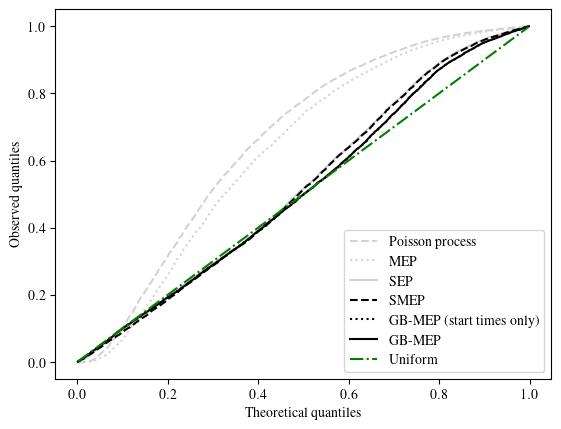

In [49]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.plot(x, y_poisson, label='Poisson process', ls='dashed', c='lightgray')
plt.plot(x, y_mep, label='MEP', ls='dotted', c='lightgray')
plt.plot(x, y_sep, label='SEP', c='lightgray')
plt.plot(x, y_smep, label='SMEP', ls='dashed', c='black')
plt.plot(x, y_gbmep_start, label='GB-MEP (start times only)', ls='dotted', c='black')
plt.plot(x, y_gbmep, label='GB-MEP', c='black')
plt.plot(x, x, label='Uniform', c='green', ls='dashdot')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Observed quantiles')
plt.legend()
plt.show()

In [31]:
import scipy.stats as stats
k_poisson = stats.kstest(p_poisson, stats.uniform.cdf)
k_mep = stats.kstest(p_mep, stats.uniform.cdf)
k_sep = stats.kstest(p_sep, stats.uniform.cdf)
k_smep = stats.kstest(p_smep, stats.uniform.cdf)
k_gbmep_start = stats.kstest(p_gbmep_start, stats.uniform.cdf)
k_gbmep = stats.kstest(p_gbmep, stats.uniform.cdf)

In [32]:
k_poisson, k_mep, k_sep, k_smep, k_gbmep_start, k_gbmep

(KstestResult(statistic=0.21387282682984698, pvalue=2.374962696518135e-131, statistic_location=0.8058973667071476, statistic_sign=-1),
 KstestResult(statistic=0.1935448231626662, pvalue=1.9056123113389757e-107, statistic_location=0.8785141483160405, statistic_sign=-1),
 KstestResult(statistic=0.1145891874202532, pvalue=9.553718104475358e-38, statistic_location=0.42379164140798325, statistic_sign=-1),
 KstestResult(statistic=0.06190842745749958, pvalue=2.6425439929873835e-11, statistic_location=0.5616016789912419, statistic_sign=-1),
 KstestResult(statistic=0.1080912808052853, pvalue=1.264200910349951e-33, statistic_location=0.9136127531979233, statistic_sign=-1),
 KstestResult(statistic=0.04705693782306175, pvalue=1.034109506306912e-06, statistic_location=0.588467980767847, statistic_sign=-1))